Calculating the Gain and Readnoise of Evora
=====

Since apparently nobody ever wrote down the gain and readnoise of Evora, I decided to calculate them myself.

The gain calculation is based on a simplified version of the technique described in [Gosmeyer & Baggett 2015](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2015-14.pdf), and the readnoise is calculated according to the technique described by [Richmond](http://spiff.rit.edu/classes/phys373/lectures/readout/readout.html). (Note that the readnoise is for a 2x2 binned image, which is standard on Evora.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# if you're still on python 2:
# from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from evora_utils import choose_dark

Gain
----

To calculate the gain, we take a pair of flat fields (ideally with roughly the same overall signal) and create two new images from them, a mean and a difference image, and sigma clip them to get rid of anomalously high- or low-signal regions, such as star trails and dead pixels `astropy.stats.sigma_clip` defaults to a 3&sigma; threshold and ``np.median`` for the centering function.

In [10]:
def make_flat_pairs(pair):
    im1, im2 = pair
    with fits.open(im1) as f:
        exptime1 = f[0].header['EXPTIME']
        f1 = f[0].data.astype(float)
    with fits.open(im2) as f:
        exptime2 = f[0].header['EXPTIME']
        f2 = f[0].data.astype(float)
    # assumes fits files are uncalibrated, so we subtract dark + bias
    dark1 = choose_dark(exptime1)
    dark2 = choose_dark(exptime2)
    bias = fits.getdata('biases/bias_medcombine.fits', 0)
    f1 -= (dark1 + bias)
    f2 -= (dark2 + bias)
    avg = sigma_clip((f1 + f2) / 2)
    diff = sigma_clip(f1 - f2)
    return avg, diff

In [3]:
# make a list of tuples of all flat pairs we want to use
# this is not the optimal way to do this but it'll do

flatpairs = [('flats_0716/Flat_r_0{}.fits'.format(str(i).zfill(2)),
              'flats_0716/Flat_r_0{}.fits'.format(str(i+1).zfill(2))) for i in range(1,9)]
flatpairs += [('flats_0717/Flat_r_0{}.fits'.format(str(i).zfill(2)),
               'flats_0717/Flat_r_0{}.fits'.format(str(i+1).zfill(2))) for i in range(1,9)]
flatpairs += [('flats_0718/r_flat_{}.fits'.format(str(i).zfill(2)),
               'flats_0718/r_flat_{}.fits'.format(str(i+1).zfill(2))) for i in range(1,5)]
flatpairs += [('flats_0718/flat_r_dawn_{}.fits'.format(str(i).zfill(2)),
               'flats_0718/flat_r_dawn_{}.fits'.format(str(i+1).zfill(2))) for i in range(1,5)]

For each flat-field pair, we subdivide the mean and difference images into 64 64x64 pixel regions (isn't that pleasing?), sigma-clip each subregion one more time to get rid of any local anomalies not picked up by the global sigma clipping, and take the average of the mean subregion and the variance of the difference subregion. These are the quantities that go into the gain calculation.

In [4]:
means = []
variances = []

for pair in flatpairs:
    avg, diff = make_flat_pairs(pair)
    for i in np.arange(8) * 64:
        for j in np.arange(8) * 64:
            avg_cut = sigma_clip(avg[i:i+64,j:j+64])
            diff_cut = sigma_clip(diff[i:i+64,j:j+64])
            means.append(avg_cut.data[~avg_cut.mask].mean())
            variances.append(diff_cut.data[~diff_cut.mask].std()**2)

Finally, we fit a line to the means vs. variances, and the inverse of the slope is the gain.

Gain = 0.5459052464692201 electrons/ADU


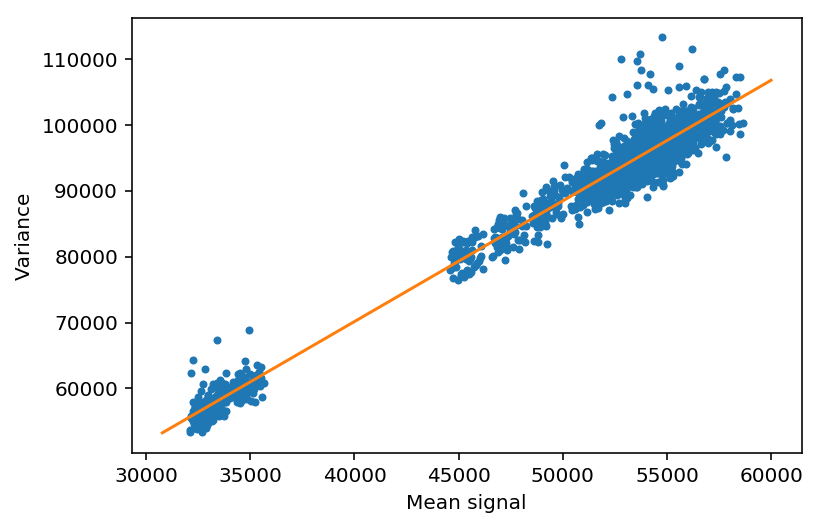

In [5]:
plt.plot(means, variances, '.')
slope, intercept = np.polyfit(means, variances, 1)
gain = 1/slope
xlim = np.array(plt.gca().get_xlim())
plt.plot(xlim, slope*xlim+intercept)
print('Gain = {} electrons/ADU'.format(gain))
plt.xlabel('Mean signal')
plt.ylabel('Variance')

Readnoise
--------

The readnoise is a similar but simpler calculation using biases. The readnoise is the standard deviation of the difference of a pair of biases divided by $\sqrt{2}$.

In [6]:
def make_bias_pairs(pair):
    im1, im2 = pair
    f1 = fits.getdata(im1, 0).astype(float)
    f2 = fits.getdata(im2, 0).astype(float)
    diff = sigma_clip(f1 - f2)
    return diff

In [7]:
bias_pairs = [('biases/bias_series_0{}.fits'.format(str(i).zfill(2)),
               'biases/bias_series_0{}.fits'.format(str(i+1).zfill(2))) for i in range(1,20)]

For a more robust measurement, we average the readnoise using a set of 20 biases, and convert it from ADU to electrons with our measured gain.

In [9]:
ronoise = []
for pair in bias_pairs:
    bias = make_bias_pairs(pair)
    ronoise.append(bias.data[~bias.mask].std()/(2**0.5))
    
print(np.mean(ronoise), np.mean(ronoise)*gain)
print(np.median(ronoise), np.median(ronoise)*gain)

4.09043135583 2.23298793747
4.09346082102 2.23464173841
